## Workflow for treating missing values and three tyes of missing data

**Workflow:**[1]  
(1) convert all missing values to null values  
(2) analyze the amount and type of missingness in the data  
(3) appropriately delete or impute missing values  
(4) evaluate and compare the perfomances of the treated/imputed dataset  

This notebook (Part 1) covers Step1 and Step2 for Titanic Kaggle Competition. The next notebook (Part 2) will cover Step3 and Step4.

**Rubin (1976) classified missing data problems into three categories:**[2]  
(1) **MCAR**, missing completely at random. If the probability of being missing is the same for all cases, then the data are said to be missing completely at random (MCAR). This effectively implies that causes of the missing data are unrelated to the data.  
(2) **MAR**, missing at random.If the probability of being missing is the same only within groups defined by the observed data, then the data are missing at random (MAR). MAR is a much broader class than MCAR.  
(3) **MNAR**, missing not at random.If neither MCAR nor MAR holds, then we speak of missing not at random (MNAR).

## Load libraries, packages, modules and data

In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import kaggle
import os

#missingno is a python library enables a quick visual summary of the completeness of your dataset.
import missingno as msno

In [49]:
#load train data
#train_df = pd.read_csv('../input/titanic/train.csv')
#test_df = pd.read_csv('../input/titanic/test.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
#create a new column 'Is_train' to differentiate the training data from the testing data, 1 = training, 0 = testing
train_df['Is_train'] = 1
test_df['Is_train'] = 0
#create the 'Survived' column filled with null values in the testing data
#so as to share the same columns as the training data
test_df['Survived'] = np.nan
#combine the trainning data and testing data
full_df = pd.concat([train_df, test_df], ignore_index=True)
# delete the two dataframes which are no longer needed
del train_df, test_df

## Convert all missing values to null values (None, np.nan)

### Find the missing values which are not null values yet

In [50]:
#Check the data type of each column
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Is_train     1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


**Finding:**   
'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked' are of object type.   
The rest are numerical (int or float).   

#### Check the columns of object dtype
Check if any of the columns which are supposed to be numerical types are now object type.
The existence of missing values makes numerical columns into object dtype.

In [51]:
#Find the columns of object dtype
object_columns = [c for c in full_df.columns if full_df[c].dtype == 'object']
object_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [52]:
#Get the statistics of each object column (most frequent values, etc.)
full_df[object_columns].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [53]:
#Look for common symbols for missing values, like '?', 'NA', '-', '.', 'unknown'
i=1
for c in object_columns:
    print(str(i)+'.', "Top 10 unique values for column '{}':".format(c))
    unique_values = full_df[c].dropna().unique()
    print(full_df[c].value_counts().index.to_list()[:10], '\n')
    unique_values_lowercase = np.char.lower(unique_values.astype('str'))
    print("Is 'na'(case insensitive) one of its unique values?", 'na' in unique_values_lowercase, '\n')    
    print("Is 'unknown' (case insensitive) one of its unique values?", 'unknown' in unique_values_lowercase, '\n')
    i+=1

1. Top 10 unique values for column 'Name':
['Connolly, Miss. Kate', 'Kelly, Mr. James', 'Wright, Miss. Marion', 'Fox, Mr. Patrick', 'Goodwin, Master. William Frederick', 'Portaluppi, Mr. Emilio Ilario Giuseppe', 'Ostby, Miss. Helene Ragnhild', 'Pulbaum, Mr. Franz', 'Thayer, Mrs. John Borland (Marian Longstreth Morris)', 'Emanuel, Miss. Virginia Ethel'] 

Is 'na'(case insensitive) one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

2. Top 10 unique values for column 'Sex':
['male', 'female'] 

Is 'na'(case insensitive) one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

3. Top 10 unique values for column 'Ticket':
['CA. 2343', '1601', 'CA 2144', '347077', '347082', 'PC 17608', 'S.O.C. 14879', '3101295', '113781', '382652'] 

Is 'na'(case insensitive) one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

4. Top 10 unique values for column 'Cabin':


**Finding:**   
The common symbols or words representing missing values are not found in the Object columns. 

#### Check the numerical columns

In [54]:
#Look for values out of expected data range, like 0 for age, or extremely large number like 9999 for age
full_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Is_train
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [55]:
print('{} fare values are zero.'.format(np.sum(full_df.Fare==0)))
full_df[full_df.Fare==0]

17 fare values are zero.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,1
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,1
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,1
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,1
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,1
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,1
481,482,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,1
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,1
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,1


**Finding & Analysis:**  
The minimum fare is zero, involving 17 tickets.It may indicate free tickets or missing values.However, Tammy found the evidence about the complimentary ticket for John George( https://www.kaggle.com/c/titanic/discussion/10570). As not any evidence was found about the missing fare data marked as 0, I interpreted the value 0 as it is (meaning free ticket).

No unusal numerical values have been found representing missing values.

**Conclusion:**   
All the missing values are already null values. So no conversion is needed.

## Analyze the number and type of missing values in the data

### Analyze the number and percentages of missing values

In [56]:
#number of missing values
missingness = full_df.isnull().sum().to_frame(name='Number') 

#percentage of missing values
missingness['Percentage %'] = round(missingness['Number']/len(full_df)*100)

missingness

,Number,Percentage %
PassengerId,0,0.0
Survived,418,32.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,263,20.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,1,0.0


**Finding:**  
1014 (77%) Cabin values are missing.Very large proportion!  
263 (20%) Age values are missing. Not small proportion.  
1 Fare value and 2 Embarked values are missing. Very small proportions.

### Analyze the types of missingness (MCAR, MAR, MNAR)

#### Look for patterns of missingness related with column values

In [57]:
s = full_df[full_df.Is_train==1].isnull().any()
cols_missing = s.where(s==True).dropna().index.to_list()
cols_missing

['Age', 'Cabin', 'Embarked']

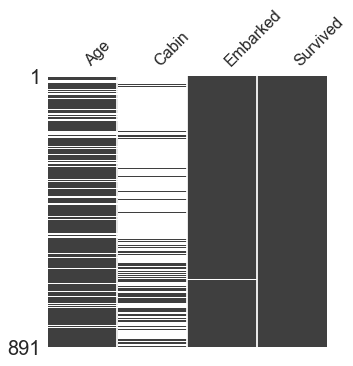

In [58]:
#Check nullity matrix for the columns with missingness and the 'Survived' column
train_sorted = full_df[full_df.Is_train==1].sort_values(by='Survived')
cols_matrix = cols_missing.copy()
cols_matrix.append('Survived')
msno.matrix(train_sorted[cols_matrix], figsize=(5, 5), sparkline=False);

In [59]:
def missingness_by_value(col1, col2, df=full_df):
    """
    check the missingness (%) of a colomn varied by the values of another column
    
    Args:
    col1 (str): the name of a column with missing values
    col2 (str): the name of a column of which the values may affect the missingness of col1
    df (pd.DataFrame) : the dataframe contains both col1 and col2
    """
    for v in np.sort(df[col2].dropna().unique()):
        missingness = df.loc[df[col2]==v, col1].isnull().mean()*100
        print("Missingness percentage of {} when the value of {} equals {}: {}%".format(col1, col2, v, round(missingness)))

In [60]:
#check the missingness of 'Cabin' column varied by the values of 'Survived' column
missingness_by_value('Cabin', 'Survived')

Missingness percentage of Cabin when the value of Survived equals 0.0: 88.0%
Missingness percentage of Cabin when the value of Survived equals 1.0: 60.0%


In [61]:
missingness_by_value('Age', 'Survived')

Missingness percentage of Age when the value of Survived equals 0.0: 23.0%
Missingness percentage of Age when the value of Survived equals 1.0: 15.0%


**Finding & Analysis:**  
The missing values are shown as white lines in the msno matrix.  

In the matrix, the upper part of the 'Cabin' column  is whiter than its lower part, indicating that more missing values of 'Cabin' are found for the victims than for the survivors.It's confirmed by checking the missing percentages for the survivors and the victims. So the missingness of 'Cabin' column can not be categorized as 'MCAR'.

The 'Age' column is the same as 'Cabin' so its missingness can not be categorized as 'MCAR' either.   

Even though the two missing values of 'Embarked' are all for the survivors, considering the very few missing values (only 2), it doesn't necessarily mean the strong relationship between the 'Survived' variable and the missingness of 'Embarked'. Since only a couple of 'Embarked' values are missing, its missingness can be categorized as 'MCAR'.

Only one 'Fare' value is missing. Its missingness can be categorized as 'MCAR'.

Nullity matrix for data sorted by column 'PassengerId'


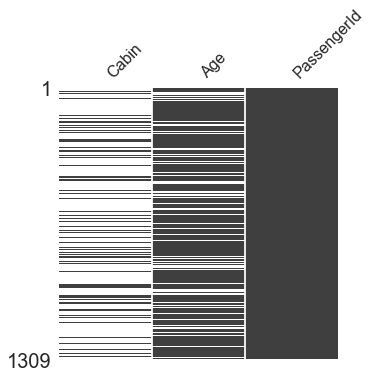

Nullity matrix for data sorted by column 'Pclass'


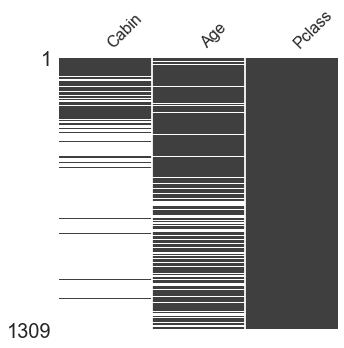

Nullity matrix for data sorted by column 'Name'


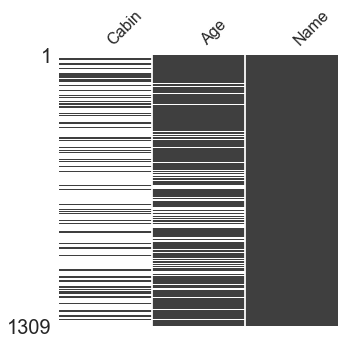

Nullity matrix for data sorted by column 'Sex'


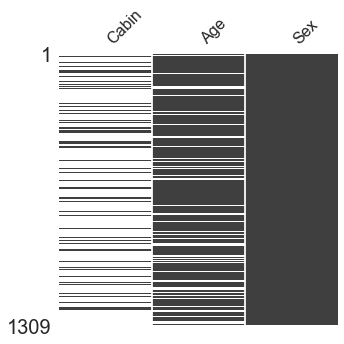

Nullity matrix for data sorted by column 'Age'


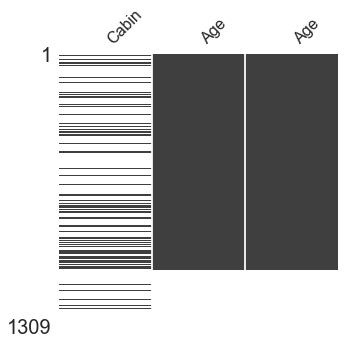

Nullity matrix for data sorted by column 'SibSp'


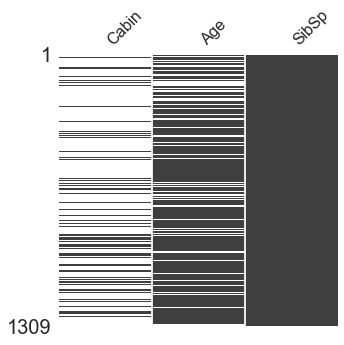

Nullity matrix for data sorted by column 'Parch'


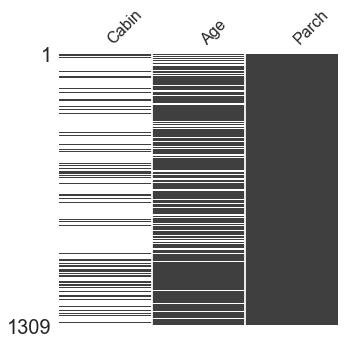

Nullity matrix for data sorted by column 'Ticket'


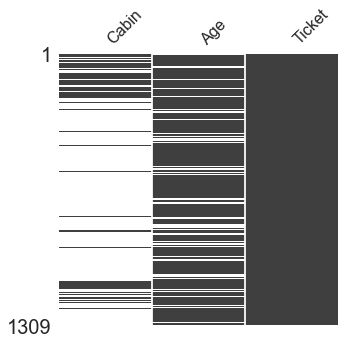

Nullity matrix for data sorted by column 'Fare'


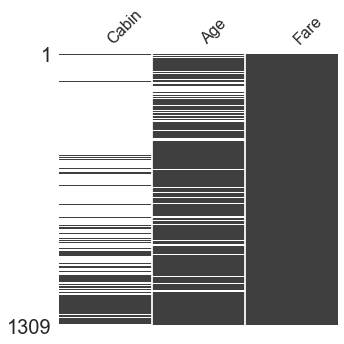

Nullity matrix for data sorted by column 'Cabin'


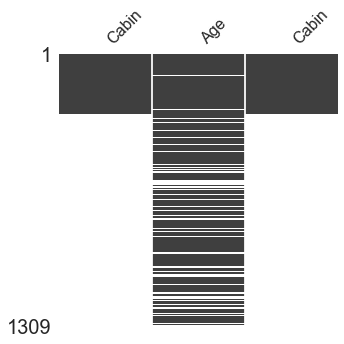

Nullity matrix for data sorted by column 'Embarked'


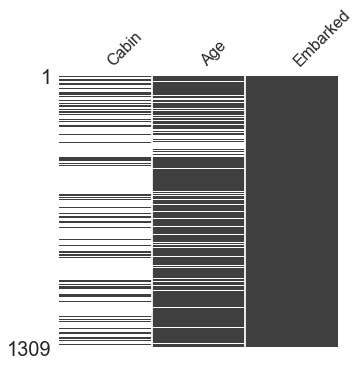

Nullity matrix for data sorted by column 'Is_train'


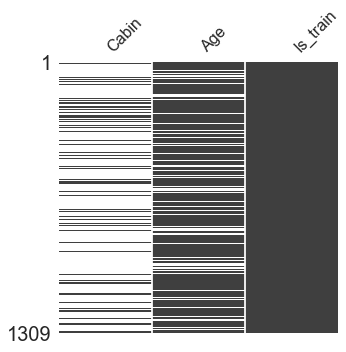

In [62]:
#check if the variables' values affect the missingness of 'Cabin' or 'Age'
for c in full_df.columns:
    if c=='Survived':
        continue
    full_df_sorted = full_df.sort_values(by=c)
    cols_matrix = ['Cabin', 'Age']
    cols_matrix.append(c)
    print("Nullity matrix for data sorted by column '{}'".format(c))
    msno.matrix(full_df_sorted[cols_matrix], figsize=(5, 5), sparkline=False)
    plt.show()

In [63]:
missingness_by_value('Cabin', 'Pclass')

Missingness percentage of Cabin when the value of Pclass equals 1: 21.0%
Missingness percentage of Cabin when the value of Pclass equals 2: 92.0%
Missingness percentage of Cabin when the value of Pclass equals 3: 98.0%


In [64]:
missingness_by_value('Age', 'Pclass')

Missingness percentage of Age when the value of Pclass equals 1: 12.0%
Missingness percentage of Age when the value of Pclass equals 2: 6.0%
Missingness percentage of Age when the value of Pclass equals 3: 29.0%


In [65]:
np.sort(full_df['Ticket'].unique())

array(['110152', '110413', '110465', '110469', '110489', '110564',
       '110813', '111163', '111240', '111320', '111361', '111369',
       '111426', '111427', '111428', '112050', '112051', '112052',
       '112053', '112058', '112059', '112277', '112377', '112378',
       '112379', '112901', '113028', '113038', '113043', '113044',
       '113050', '113051', '113054', '113055', '113056', '113059',
       '113501', '113503', '113505', '113509', '113510', '113514',
       '113572', '113760', '113767', '113773', '113776', '113778',
       '113780', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113790', '113791', '113792', '113794',
       '113795', '113796', '113798', '113800', '113801', '113803',
       '113804', '113806', '113807', '11668', '11751', '11752', '11753',
       '11755', '11765', '11767', '11769', '11770', '11771', '11774',
       '11778', '11813', '11967', '1222', '12233', '12460', '12749',
       '13049', '13050', '13213', '13214', '13236',

In [66]:
full_df['Pure_Digit_Ticket'] = full_df['Ticket'].apply(str.isdigit)
missingness_by_value('Cabin', 'Pure_Digit_Ticket', full_df)

Missingness percentage of Cabin when the value of Pure_Digit_Ticket equals False: 76.0%
Missingness percentage of Cabin when the value of Pure_Digit_Ticket equals True: 78.0%


In [67]:
np.sort(full_df['Name'].unique())

array(['Abbing, Mr. Anthony', 'Abbott, Master. Eugene Joseph',
       'Abbott, Mr. Rossmore Edward', ...,
       'van Billiard, Master. Walter John',
       'van Billiard, Mr. Austin Blyler', 'van Melkebeke, Mr. Philemon'],
      dtype=object)

In [68]:
missingness_by_value('Age', 'Embarked')

Missingness percentage of Age when the value of Embarked equals C: 21.0%
Missingness percentage of Age when the value of Embarked equals Q: 59.0%
Missingness percentage of Age when the value of Embarked equals S: 14.0%


**Finding & Analysis:**  
According to the matrices, there are fewer missing values of 'Cabin' at smaller value of 'Pclass' and 'Ticket'. 
With the calculation of 'Cabin' missingness, the percentageis 21% for Pclass 1, 92% for Pclass 2, 98% for Pclass 3.   
Most tickets are unique, the pure-digit values are smaller than the rest. After separating them into two groups, their missingness were calculated respectively and their results are the same.It will take further investigation to identify what ticket groups have fewer missingness.

According to the webpage (https://www.encyclopedia-titanica.org/cabins.html), 'The allocation of cabins on the Titanic is a source of continuing interest and endless speculation. Apart from the recollections of survivors and a few tickets and boarding cards, the only authoritative source of cabin data is the incomplete first class passenger list recovered with the body of steward Herbert Cave.'. It's consistent with my finding from the data analysis. So there are fewer missing values of 'Cabin'for Pclass 1 and the survivors.

Besides, the matrices also show that there are fewer missing values of 'Age' at smaller value of 'Name' and 'Pclass' and bigger value of 'Embarked'.
Based on the calculation, the missingness of 'Age' is 64% for Embarked Q, much higher than for Embarkek C or S (23%, 14%). 12% for Pclass1, 6% for Pclass2, 29% for Pclass3.   
Each name values are unique. It will take further investigation to identify what name groups have more missingness.

#### Check the dependency of missingness between columns ('Cabin', 'Age')

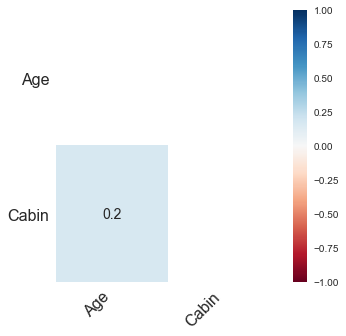

In [69]:
msno.heatmap(full_df[['Age', 'Cabin']], figsize=(5,5));

**Finding:**   
The dependency of missingness between 'Cabin' and 'Age' is low.

**Conclusion:**   

Since 'Fare' and 'Embarked' have only one or two missing values, they can be categorized as MCAR (missing completely at random).

'Cabin' has 77% missing values. Its missingness varies with 'Survived' and 'Pclass' variables. So it's categorized as MAR (missing at random).

'Age' has 20% missing values. Its missingness varies with 'Survived', 'Pclass', 'Embarked'. So it's also categorized as MAR.

## Delete or impute missing values

For small number of MCAR missin values, like 'Fare' and 'Embarked', either deletion or imputation is workable.

For large number of missingness values, like 'Cabin', the variable can be dropped.

### For 'Fare'

In [70]:
#display the record with missing fare value
full_df.loc[full_df.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Pure_Digit_Ticket
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0,True


**Finding:**   
The record is in the test data set. So the fare value has to be imputed.   
In the [notebook](https://www.kaggle.com/bofangli/make-fare-crystal-clear-fare-sharing-zero-fare?scriptVersionId=47733767), it's found that the records of the same ticket number share the same fare value.   
So if there's any other record of '3701', it should have the same fare value.

In [71]:
#check if there is any other record with the same ticket number
full_df[full_df.Ticket=='3701']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Pure_Digit_Ticket
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0,True


**Finding:**   
No other record is found of '3701' ticket.  
As the fare is strongly correlated with the pclass and the fare increases with the ticket group size, the missing fare value can be filled with the median fare value (7.8292, refered in the [notebook](https://www.kaggle.com/bofangli/make-fare-crystal-clear-fare-sharing-zero-fare?scriptVersionId=47733767)) of the samples which share the same pclass and ticket group size (pclass=3, ticket group size=1).

In [72]:
#impute
full_df.loc[1043, 'Fare'] = 7.8292
full_df.loc[[1043]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Pure_Digit_Ticket
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,7.8292,NaN,S,0,True


### For 'Embarked'   

In [73]:
#display the record with missing Embarked value
full_df.loc[full_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Pure_Digit_Ticket
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,True
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,True


**Finding:**   
The two records are in the train data sets. Either imputation or deletion is workable.   
I choose imputation with the most frequent value, 'S'.

In [74]:
#impute
full_df.loc[[61, 829], 'Embarked'] = 'S'
full_df.loc[[61, 829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_train,Pure_Digit_Ticket
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S,1,True
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S,1,True


### For 'Cabin'

In [75]:
#Drop 'Cabin'
full_df.drop('Cabin', axis=1, inplace=True)

full_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Is_train', 'Pure_Digit_Ticket'],
      dtype='object')

### For 'Age'

In [77]:
#check how many records with missing age values there are in train data set and test data set respectively
full_df.loc[full_df.Age.isnull(), 'Is_train'].value_counts()

1    177
0     86
Name: Is_train, dtype: int64

**Finding:**   
There are a few missing age values both in the train data set and the test data set.
Deletion is not an option. A proper imputation strategy needs to be made.

## References:
[1] [DataCamp Course "Dealing with Missing Data in Python"](https://www.datacamp.com/courses/dealing-with-missing-data-in-python)  
[2] [Flexible Imputation of Missing Data, by Stef van Buuren](https://stefvanbuuren.name/fimd/sec-MCAR.html)